# Load financial data

In [1]:
import pandas as pd
import numpy as np
# data for Eurex futures are in this store
store = pd.HDFStore('/data/data/QH/L1.h5', 'r')
# to get one day
df = store.get('xFGBL/20140922')
# we examine trades between multilpe components %%bashed on volume buckets:
bins4D = (0,1,3,10, np.inf)

In [2]:
def PriceUp(df):
    return (df.PriceMove > 0).values

def PriceDown(df):
    return (df.PriceMove < 0).values

def MarketOrdersAsk(df):
    return (df.PriceMove == 0).values * (df.AskQtyAfter > df.AskQtyBefore).values

def MarketOrdersBid(df):
    return (df.PriceMove == 0).values * (df.BidQtyAfter > df.BidQtyBefore).values    

def GetOrderBookEvents(df):
    """ Given df representing one day of data, returns list of array representing
        order book events for mid-price moves (ask/bid), number of market orders 
        (ask/bid), number of limit order (ask/bid), number of cancel orders (ask/bid)"""
    
    out = []
    out += [np.copy(df.loc[PriceUp(df), "Time"].values)]
    out += [np.copy(df.loc[PriceDown(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersAsk(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersBid(df), "Time"].values)]
    return out

def GetComponents(df, vol_bins):
    """ Given df representing one day of data, returns list of array representing 
        trades time for each volume component"""
    
    mask = lambda x, y: (df.OrderType==0).values * (np.abs(df.Volume.values)>x) * (np.abs(df.Volume.values)<=y)
    out = []
    for ii in range(len(vol_bins)-1): 
        out += [np.copy(df.loc[mask(vol_bins[ii], vol_bins[ii+1]), 'Time'].values)]
    return out

In [3]:
# do estimation using one month of data
asset = 'xFGBL'
days = pd.bdate_range(start='20140101', end='20140201')
big_data = []
# 4D case
for d in days:
    try:
        df = store.get('%s/%s' %(asset, d.strftime('%Y%m%d')))
    except KeyError:
        continue
    #data = GetComponents(df, bins4D)
    data = GetOrderBookEvents(df)
    big_data.append(data)

# Covariance density has a fat tail

In [4]:
%matplotlib inline
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nphc.misc.covariance_density import cov_density

In [5]:
i = 0
j = 1
data = big_data[0]
T = max(X[-1] - X[0] for X in data)
L_j = len(data[j])/T
X, Y = cov_density(data[i], data[j], T, L_j, log_start=-3, log_end=3, n_points=100)

### Linear fit of log-log plot to know whether the covariance is integrable

In [6]:
from scipy.stats import linregress
cond = X > 5.
x = X[cond]
y = Y[cond]
slope, intercept = linregress(np.log(x), np.log(y))[:2]
print("slope = {}".format(slope))

slope = -0.3788685950893465


[]

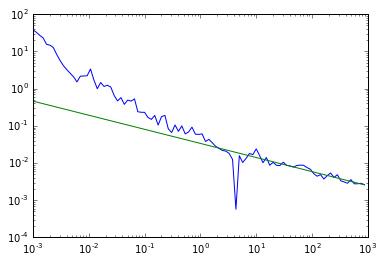

In [7]:
from math import exp
line = exp(intercept) * X**slope
plt.plot(X, Y, 'b', X, line, 'g')
plt.loglog()

# Fit (=> compute the cumulants)

In [8]:
from nphc.main import NPHC
nphc = NPHC()
nphc.fit(big_data,half_wifth=1,filtr="gaussian",method="classic")

L is computed
C is computed
K_c is computed


# Solve (=> minimize the objective function)

In [9]:
R_pred = nphc.solve(alpha=0.,training_epochs=100,display_step=20,learning_rate=1e-2,optimizer='adam')

Epoch: 0000 log10(cost)= 1.479016542
Epoch: 0020 log10(cost)= 1.445499778
Epoch: 0040 log10(cost)= 1.477139473
Epoch: 0060 log10(cost)= 1.430135131
Epoch: 0080 log10(cost)= 1.423014641
Optimization Finished!


In [10]:
d = len(nphc.L[0])
from scipy.linalg import inv
G_pred = np.eye(d) - inv(R_pred)

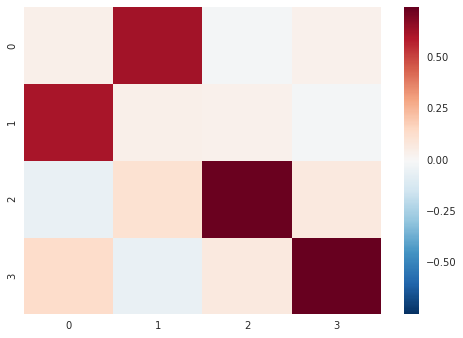

In [11]:
import seaborn as sns
sns.heatmap(G_pred)